In [27]:
import pandas as pd

from IPython.display import display
from sklearn import metrics
from scipy.spatial import distance
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

In [2]:
# Read file
icfes = pd.read_csv("./data/ICFES/icfes_preprocessing.csv", low_memory=False, encoding="utf-8")

print(icfes.shape)

(554679, 68)


In [97]:
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

columns = ['COLE_AREA_UBICACION', 'COLE_BILINGUE']

columns = [
    'FAMI_COMECARNEPESCADOHUEVO', 
    #'FAMI_COMECEREALFRUTOSLEGUMBRE', 
    #'FAMI_COMELECHEDERIVADOS', 
    #'FAMI_CUARTOSHOGAR', 
    #'FAMI_EDUCACIONMADRE', 
    #'FAMI_EDUCACIONPADRE', 
    #'FAMI_ESTRATOVIVIENDA', 
    #'FAMI_NUMLIBROS', 
    #'FAMI_PERSONASHOGAR', 
    #'FAMI_SITUACIONECONOMICA', 
    #'FAMI_TIENEAUTOMOVIL', 
    #'FAMI_TIENECOMPUTADOR', 
    #'FAMI_TIENECONSOLAVIDEOJUEGOS', 
    #'FAMI_TIENEHORNOMICROOGAS', 
    #'FAMI_TIENEINTERNET', 
    #'FAMI_TIENELAVADORA', 
    #'FAMI_TIENEMOTOCICLETA', 
    #'FAMI_TIENESERVICIOTV', 
    #'FAMI_TRABAJOLABORMADRE', 
    'FAMI_TRABAJOLABORPADRE',
    'DESEMP_INGLES'
]

X = icfes[columns].values[:1000, :]

print(X.shape)

km = KModes(n_clusters=2, init='Cao', verbose=2)
cluster_labels = km.fit_predict(X)

# Print cluster centroids of the trained model.
print("centroids", km.cluster_centroids_)

print("cluster_labels", cluster_labels.shape)

(1000, 3)
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1185.0
centroids [['Todos o casi todos los dias'
  'Trabaja como profesional (por ejemplo médico, abogado, ingeniero)'
  'B+']
 ['Todos o casi todos los dias'
  'Es dueño de un negocio grande, tiene un cargo de nivel directivo o gerencial'
  'B1']]
cluster_labels (1000,)


In [98]:
import time

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def gower_distance(x, y):
    d = 0
    for i in range(len(x)):
        if is_number(x[i]):
            d += distance.euclidean(x[i], y[i])
        else:
            d += distance.hamming(x[i], y[i])
    
    d = d / len(x)
    
    return d

def gower_distance_matrix(X):
    m = X.shape[0]
    
    # Calc one part of the matrix
    result = [[gower_distance(X[i], X[j]) if i < j else 0 for i in range(m)] for j in range(m)]
    
    # Copy the values from the other part
    result = [[result[i][j] if i > j else result[j][i] for i in range(m)] for j in range(m)]
        
    return np.asarray(result)

start_time = time.time()

distance_matrix = gower_distance_matrix(X)

print("--- {0} seconds ---".format(time.time() - start_time))

silhouette_sk = metrics.silhouette_score(distance_matrix, labels=cluster_labels, metric='precomputed', n_jobs=-1)

print(silhouette_sk)

distance_matrix

--- 23.341911554336548 seconds ---
0.21205714242312007


array([[0.        , 1.        , 1.        , ..., 0.66666667, 1.        ,
        1.        ],
       [1.        , 0.        , 0.66666667, ..., 0.66666667, 0.66666667,
        0.66666667],
       [1.        , 0.66666667, 0.        , ..., 1.        , 0.        ,
        0.33333333],
       ...,
       [0.66666667, 0.66666667, 1.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 0.66666667, 0.        , ..., 1.        , 0.        ,
        0.33333333],
       [1.        , 0.66666667, 0.33333333, ..., 1.        , 0.33333333,
        0.        ]])

In [86]:
def plot_silhouette_score(range_n_clusters):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 1 columns
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(16, 9)

        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed.
        clusterer =  KModes(n_clusters=n_clusters, init='Cao')
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = metrics.silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = metrics.silhouette_samples(distance_matrix, cluster_labels, metric='precomputed')

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.Set1(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(clusterer.cluster_centroids_[i]))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KModes clustering on sample data "
                      "with n_clusters = {0}".format(n_clusters)),fontsize=14, fontweight='bold')
    
        plt.show()

For n_clusters = 2 The average silhouette_score is : 0.21205714242312007


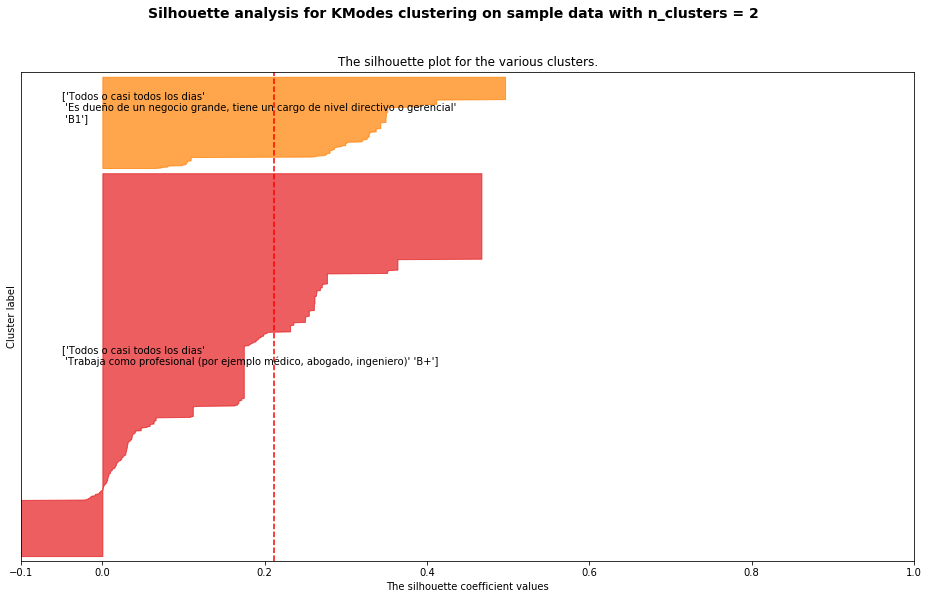

For n_clusters = 3 The average silhouette_score is : 0.2688757414156888


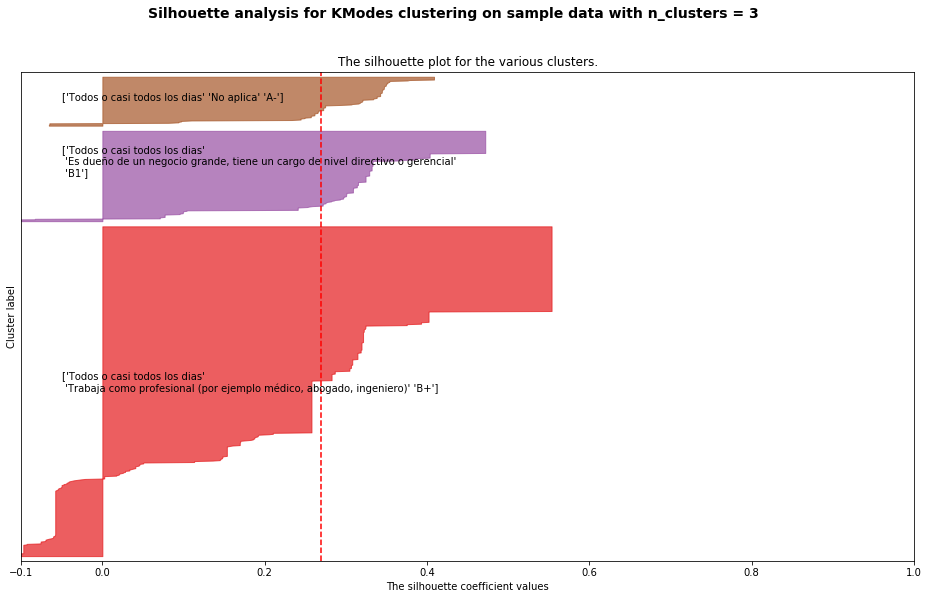

For n_clusters = 4 The average silhouette_score is : 0.27657204515232886


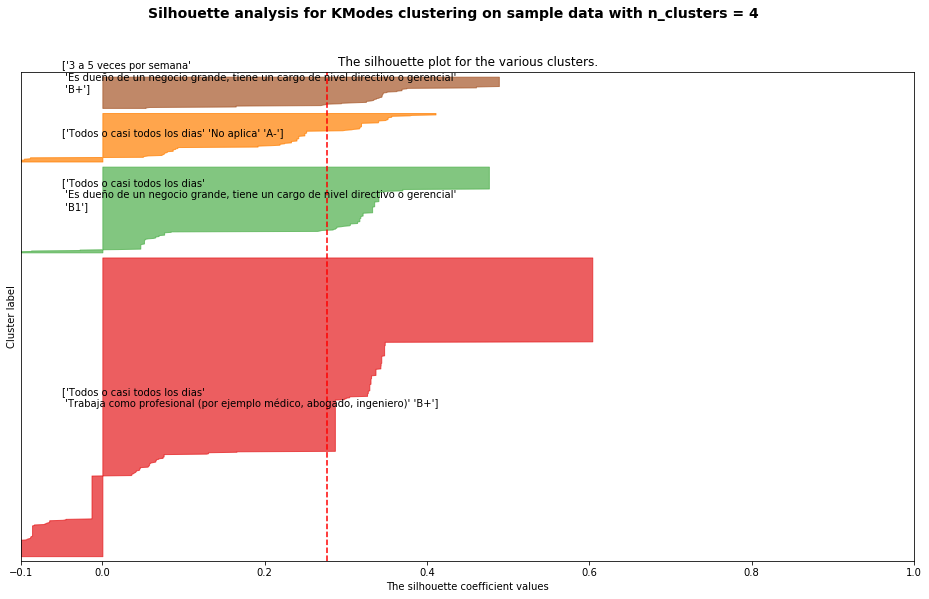

For n_clusters = 5 The average silhouette_score is : 0.29582232792431584


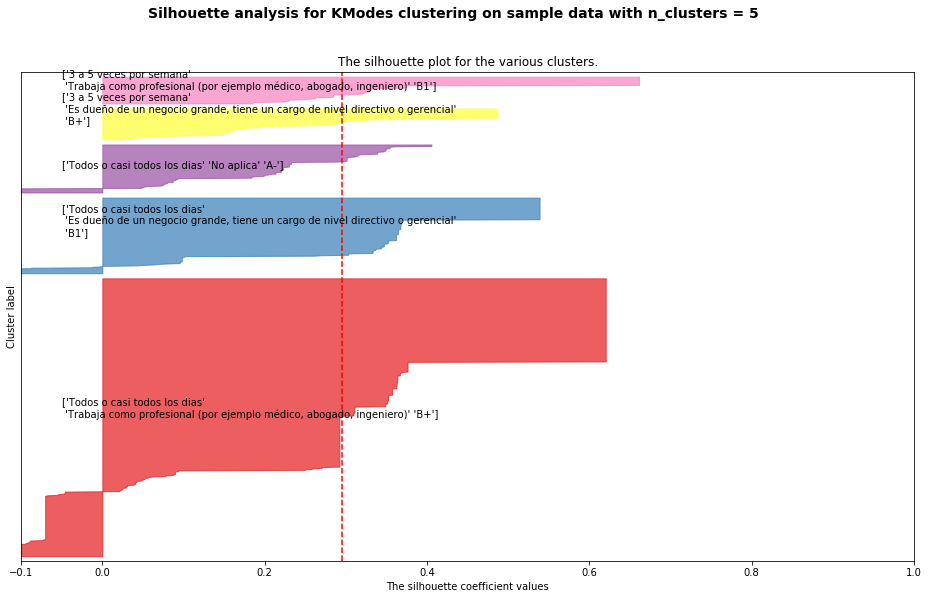

For n_clusters = 6 The average silhouette_score is : 0.3076379218144403


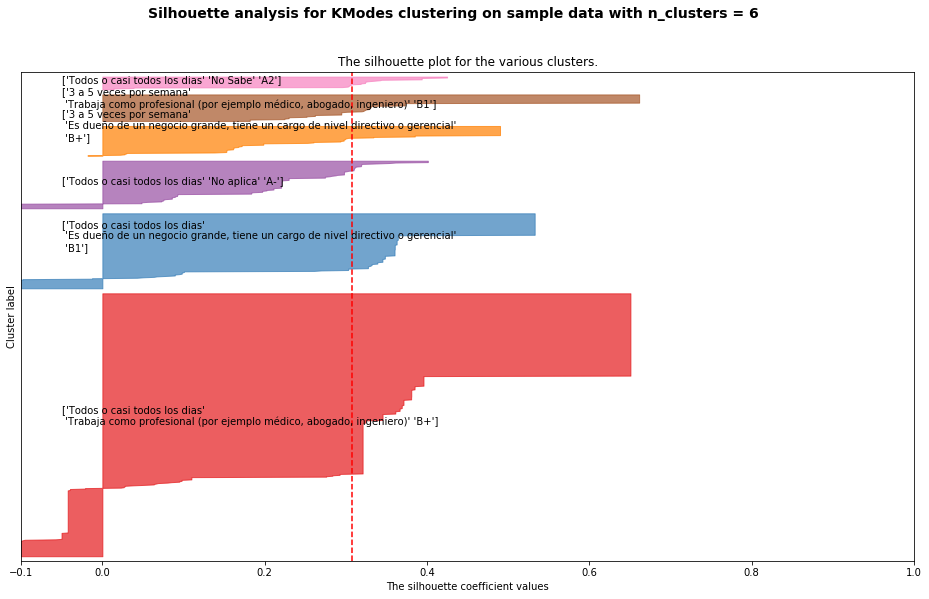

In [99]:
range_n_clusters = [2, 3, 4, 5, 6]

plot_silhouette_score(range_n_clusters)